## <b> Time series decomposition using moving averages

While analysing the quarterly beer production data we developed a methodology of stationarizing a non-stationary time series using seasonal MA and seasonal differences. We used the seasonal moving average as an estimate of the trend-cycle component and computed periodic differences on the residuals left by the MA.
  
Another approach could have been deducting both the seasonal MA and seasonal residuals from the original series and checking for randomness of the final residuals. This approach assumes that the beer production series is an additive sum of the trend-cycle and seasonal components and what is left after removing the aforementioned two are random variations.

This notebook illustrates time series decomposition by moving averages. Both additive and multiplicative models are demonstrated.

In [1]:
import os
import pandas as pd
import numpy as np
from statsmodels.tsa import stattools
%matplotlib inline
from matplotlib import pyplot as plt

/usr/local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Let us demonstrate the addtive model using US Airlines monthly miles flown dataset.

In [2]:
#read the data from into a pandas.DataFrame
air_miles = pd.read_csv(
    '../Data Files/us-airlines-monthly-aircraft-miles-flown.csv', 
    parse_dates =['Month'], index_col=['Month']
)

In [3]:
# Let's find out the shape of the DataFrame
print('Shape of the DataFrame:', air_miles.shape)

Shape of the DataFrame: (97, 1)


In [4]:
# Let's see first 5 rows of it
air_miles.head(5)

,U.S. airlines: monthly aircraft miles flown (Millions) 1963 -1970
Month,
1963-01,6827.0
1963-02,6178.0
1963-03,7084.0
1963-04,8162.0
1963-05,8462.0


In [5]:
# Let's rename the 2nd column
air_miles.rename(columns={
    'U.S. airlines: monthly aircraft miles flown (Millions) 1963 -1970':'Air miles flown'
}, inplace=True)

In [6]:
# Check for missing values and remove the row
missing = pd.isnull(air_miles['Air miles flown'])
print('Number of missing values found:', missing.sum())
air_miles = air_miles.loc[~missing, :]

Number of missing values found: 1


In [7]:
# Let us estimate the trend component by 2X12 monthly moving average
MA12 = air_miles['Air miles flown'].rolling(window=12).mean()
trendComp = MA12.rolling(window=2).mean()

In [8]:
# Let us now compute the residuals after removing the trend component
residuals = air_miles['Air miles flown'] - trendComp

# To find the sesonal compute we have to take monthwise average of these residuals
month = air_miles.index.map(lambda d: d[-2:])
monthwise_avg = residuals.groupby(by=month).aggregate(['mean'])
# Number of years for which we have the data
nb_years = 1970-1963+1

seasonalComp = np.array([monthwise_avg.values]*nb_years).reshape((12*nb_years,))

In [9]:
seasonalComp[0:2]

array([-1288.48214286, -1771.28571429])

In [10]:
# After deducting the trend and seasonal component we are left with irregular variations
irr_var = air_miles['Air miles flown'] - trendComp - seasonalComp

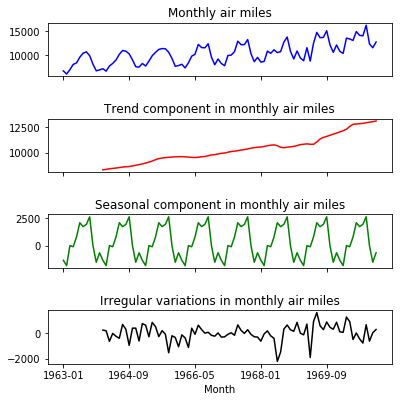

In [11]:
# Plot the original time series, trend, seasonal and random components
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(5.5, 5.5)

air_miles['Air miles flown'].plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('Monthly air miles')

pd.Series(data=trendComp, index=air_miles.index).plot(ax=axarr[1], color='r', linestyle='-')
axarr[1].set_title('Trend component in monthly air miles')

pd.Series(data=seasonalComp, index=air_miles.index).plot(ax=axarr[2], color='g', linestyle='-')
axarr[2].set_title('Seasonal component in monthly air miles')

pd.Series(data=irr_var, index=air_miles.index).plot(ax=axarr[3], color='k', linestyle='-')
axarr[3].set_title('Irregular variations in monthly air miles')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

In [12]:
# Run ADF test on the irregular variations
adf_result = stattools.adfuller(irr_var.loc[~pd.isnull(irr_var)], autolag='AIC')

In [13]:
print('p-val of the ADF test on irregular variations in air miles flown:', adf_result[1])

p-val of the ADF test on irregular variations in air miles flown: 0.06577411025730105


The additive decompostion has been able to reduce the p-value from 0.99 in case of the original time series
(as shown in 02_04_Augmented_Dickey_Fuller_Test.ipynb) to 0.066 after decomposing. Now we will attempt decomposition of the original time using a multiplicative model. Computation of the trend-cycle component remain same. But the seasonal component is estimated as follows

In [14]:
# We start with the residuals left after removing the trend component
residuals = air_miles['Air miles flown'] / trendComp

# To find the sesonal compute we have to take monthwise average of these residuals
month = air_miles.index.map(lambda d: d[-2:])
monthwise_avg = residuals.groupby(by=month).aggregate(['mean'])
# Number of years for which we have the data
nb_years = 1970-1963+1

seasonalComp = np.array([monthwise_avg.values]*nb_years).reshape((12*nb_years,))

In [15]:
seasonalComp[0:2]

array([0.87182935, 0.82302742])

In [16]:
# After adjusting the trend and seasonal component we are left with irregular variations
irr_var = air_miles['Air miles flown'] / (trendComp * seasonalComp)

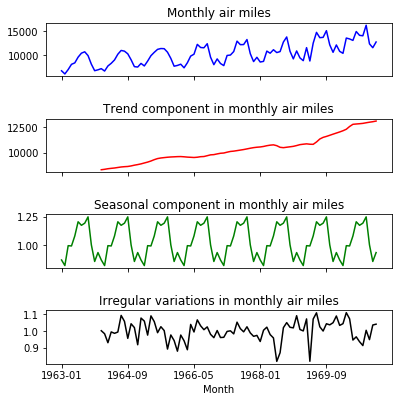

In [17]:
#Plot the original time series, trend, seasonal and random components
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(5.5, 5.5)

air_miles['Air miles flown'].plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('Monthly air miles')

pd.Series(data=trendComp, index=air_miles.index).plot(ax=axarr[1], color='r', linestyle='-')
axarr[1].set_title('Trend component in monthly air miles')

pd.Series(data=seasonalComp, index=air_miles.index).plot(ax=axarr[2], color='g', linestyle='-')
axarr[2].set_title('Seasonal component in monthly air miles')

pd.Series(data=irr_var, index=air_miles.index).plot(ax=axarr[3], color='k', linestyle='-')
axarr[3].set_title('Irregular variations in monthly air miles')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

In [18]:
# Run ADF test on the irregular variations
adf_result = stattools.adfuller(irr_var.loc[~pd.isnull(irr_var)], autolag='AIC')

In [19]:
print('p-val of the ADF test on irregular variations in air miles flown:', adf_result[1])

p-val of the ADF test on irregular variations in air miles flown: 0.00017645280908370881


Voila! The p-val has further reduced to 0.000176. The null hypothesis about non-stationarity of the irregular variations can be rejected at even a level of confidence of 99 % (alpha=0.01). This shows that the original time series has been de-stationarized to the stationary irregular variations. Besides we have estimates of both trend-cycle and seasonal components